In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
from saturation.utils import *

import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import scipy
import sklearn.metrics

from numba import jit, njit

## Simulationg time to death

Consider a crater with radius $r$ on a square plane with side length $L$. At every time step $t$, the crater loses $x$ percent of its remaining rim, where $x$ is drawn from some random distribution with values (0, 1).

At what time $t$ does the remaining rim percent drop below $m$ percent?

In [ ]:
r = 5
m = 0.5
L = 500
r_min = 3
r_max = 100

In [ ]:
@njit
def draw_x():
    return np.random.beta(a=1.05, b=5)

In [ ]:
@njit
def run_sims(r, scale, n_sims=1000, draw_x=draw_x):
    results = []

    for _ in range(n_sims):
        initial_rim = remaining_rim = 2 * np.pi * r
        
        counter = 0
        while (remaining_rim / initial_rim) > m:
            remaining_rim *= (1 - draw_x() * scale)
            counter += 1

        results.append(counter)

    return results

In [ ]:
results = run_sims(r, scale)

In [ ]:
plt.hist(results)
np.mean(results), np.std(results)

In [ ]:
alpha = 1.05
beta = 5
expected_x = alpha / (alpha + beta)

np.log(m) / np.log(1 - expected_x * scale)

## Birth-death process

Suppose we add one crater at each time step t, and decay each existing as above. What does the resulting equilibrium settle as?

$N(r, t+1) = N(r, t) + 1 - Deaths$

In [ ]:
def draw_x(alpha, r_min, r_max, size):
    return scipy.stats.pareto.rvs(alpha, scale=r_min, size=size)

In [ ]:
@njit
def do_sim(
    r,
    existing_rim_remaining,
    L
):
    for i1 in range(len(r)):
        r1 = r[i1]
        
        for i2 in range(i1):
            r2 = r[i2]
            
            if r1 >= r2:
                existing_rim_remaining[i2] *= (1.0 - np.pi * r1**2 / L**2)

    return existing_rim_remaining

In [ ]:
alpha = 3.5
m = 0.5
r_min = 3
r_max = 100
L = r_max * 5

n_time_steps = 100000
r = draw_x(alpha=alpha, r_min=r_min, r_max=r_max, size=n_time_steps)
existing_rim_remaining = np.array(np.pow(r, 2) * np.pi)
existing_rim_remaining = do_sim(r, existing_rim_remaining, L)

In [ ]:
df = pd.DataFrame()
df["r"] = r
df["rim"] = existing_rim_remaining

df["rim"] = df.rim / (df.r**2 * np.pi) > m
df = df.sort_values("r")
df["remaining"] = df.rim.sum() - df.rim.cumsum() + 1

plt.plot(
    df.r,
    df.remaining
)

## Let's try to model N(<r, t+t)

In [ ]:
@njit
def calculate_prob_lt_r(
    r: float,
    alpha: float,
    r_min: float,
    r_max: float
):
    return (1 - (r_min/r)**alpha) / (1 - (r_min/r_max)**alpha)


@njit
def calculate_average_lifetime(
    r: float,
    alpha: float,
    r_min: float,
    r_max: float,
    L: float,
    m: float
):
    expected_area = alpha * r_min**alpha * r**(2 - alpha) / (alpha - 2)
    return np.log(m) / np.log(1 - expected_area / L**2)


@njit
def calculate_n_lt_r_t(
    r: np.array,
    alpha: float,
    t: int,
    r_min: float,
    r_max: float,
    L: float,
    m
) -> np.array:
    N_lt_r_t = np.zeros(len(r))
    
    for t_idx in range(t):
        N_r_t = np.diff(np.array([0] + list(N_lt_r_t)))
        
        N_lt_r_t = (
            N_lt_r_t
            + calculate_prob_lt_r(r, alpha, r_min, r_max)
            - (N_r_t / calculate_average_lifetime(r, alpha, r_min, r_max, L, m))
        )
        
    return N_lt_r_t

In [ ]:
alpha = 3.5
m = 0.5
r_min = 3
r_max = 250
L = r_max * 2
n_steps = 100
r = np.array(range(n_steps)) * (r_max // 5 - r_min) / n_steps + r_min

result = calculate_n_lt_r_t(
    r,
    alpha,
    1000000,
    r_min,
    r_max,
    L,
    m
)

In [ ]:
plt.plot(
    r,
    # np.diff(calculate_prob_lt_r(r, alpha, r_min, r_max))
    # calculate_average_lifetime(r, alpha, r_min, r_max, L, m)
    1 - calculate_prob_lt_r(r, alpha, r_min, r_max)
)

plt.plot(
    r,
    result.max() - result
)

plt.xscale("log")
plt.yscale("log")

# Comparison to expected value

In [ ]:
def calculate_mean_truncated_pareto_circle_area(
    alpha: float,
    r: float,
    x_min: float,
    x_max: float
) -> float:
    part1 = alpha * x_min**alpha / (2 - alpha)
    part2 = (x_max**(2 - alpha) - r**(2-alpha)) / (1 - (x_min/x_max)**alpha)
    return np.pi * part1 * part2

In [ ]:
expected_areas = np.array([
    calculate_mean_truncated_pareto_circle_area(alpha, x, r_min, r_max)
    for x in df.r
])

expected_lifetimes = np.log(m) / np.log(1 - expected_areas / (L)**2)
expected_n = scipy.stats.pareto.pdf(df.r, alpha, scale=r_min) * expected_lifetimes
expected_n = (expected_n/expected_n.max()) * df.remaining.max()
plt.plot(
    df.r,
    expected_n
)

plt.plot(
    df.r,
    df.remaining
)

plt.xscale("log")
plt.yscale("log")

In [ ]:
expected_areas = np.array([
    calculate_expected_area_greater_than_r(x, scale_r, min_r, alpha, beta, n_samples=1000)
    for x in df.r
])

expected_lifetimes = np.log(m) / np.log(1 - expected_areas / (L)**2)

plt.plot(
    df.r,
    expected_lifetimes
)

In [ ]:
expected_lifetimes

## Another way to simulate

In [ ]:
import glob
from saturation.utils import *

import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import scipy
import sklearn.metrics

from numba import jit, njit

In [ ]:
@njit
def calculate_average_lifetime(
    r: float,
    alpha: float,
    r_min: float,
    r_max: float,
    L: float,
    m: float
):
    expected_area = alpha * r_min**alpha * r**(2 - alpha) / (alpha - 2)
    return np.log(m) / np.log(1 - expected_area / L**2)


@njit
def simulate_n_r_t(
    r: np.array,
    alpha: float,
    t: int,
    r_min: float,
    r_max_dist: float,
    r_max_sample: float,
    L: float,
    m: float,
    r_samples: np.array
) -> np.array:
    N_r_t = np.zeros(len(r))

    average_lifetimes = calculate_average_lifetime(r, alpha, r_min, r_max_dist, L, m)
    n_steps = len(r)
    
    n_samples = len(r_samples)
    for t_idx in range(1, t + 1):
        sampled_r = r_samples[t_idx % n_samples]
        N_r_t -= (N_r_t / average_lifetimes)
        
        if sampled_r < r_max_sample:
            idx = int((sampled_r - r_min) * n_steps / (r_max_sample - r_min))
            N_r_t[idx] += 1
            
        if t_idx % n_samples == 0:
            np.random.shuffle(r_samples)
        
    return N_r_t

In [ ]:
alpha = 3.5
m = 0.75
r_min = 3
r_max_sample = 50
r_max_dist = 250
L = r_max_dist * 2
max_t = 100000000

n_steps = 50
r = np.array(range(n_steps)) * (r_max_sample - r_min) / n_steps + r_min

r_samples = scipy.stats.pareto.rvs(alpha, scale=r_min, size=10000000)
result = simulate_n_r_t(
    r,
    alpha,
    max_t,
    r_min,
    r_max_dist,
    r_max_sample,
    L,
    m,
    r_samples
)

In [ ]:
adjusted_result = result
# adjusted_result = adjusted_result.max() - adjusted_result
plt.plot(
    r,
    adjusted_result
)

expected_n = calculate_average_lifetime(r, alpha, r_min, r_max_dist, L, m)
expected_n = (expected_n / expected_n.max()) * adjusted_result.max()
plt.plot(
    r,
    expected_n
)

expected_r = r**(-3)
expected_r = (expected_r / expected_r.max()) * adjusted_result.max()
plt.plot(
    r,
    expected_r,
    ls="dashed"
)

plt.xscale("log")
plt.yscale("log")

# Let's take a damn bat to it and simulate it all. Ugh.

In [1]:
import glob
from saturation.utils import *

import matplotlib.pyplot as plt
import pyspark.sql.functions as F
import scipy
import sklearn.metrics

from numba import jit, njit

In [2]:
@njit
def get_radius_index(
    r: float,
    r_min: float,
    r_max: float,
    n_buckets: float
):
    return int((r - r_min) / (r_max - r_min) * n_buckets)
    

@njit
def simulate(
    alpha: float,
    r_min: float,
    r_max: float,
    mrp: float,
    L: float,
    max_t: int,
    radii: np.array
):
    n_radii_buckets = 1000
    n_radii = len(radii)
    region_area = L**2
    
    crater_record_buckets = [
        [(1.0, 1.0)]
        for x in range(n_radii_buckets)
    ]

    for bucket in crater_record_buckets:
        bucket.clear()

    for t in range(1, max_t + 1):
        r = radii[t % n_radii]

        area = np.pi * r**2
        prob = area / region_area

        max_idx = get_radius_index(r, r_min, r_max, n_radii_buckets)
        for idx in range(min(max_idx + 1, n_radii_buckets - 1)):
            bucket = crater_record_buckets[idx]

            remove_indexes = []
            for bucket_idx, (radius, rim_length) in enumerate(bucket):
                if r > radius:
                    new_rim_length = rim_length * (1 - prob)
                    if new_rim_length < mrp * 2 * np.pi * radius:
                        remove_indexes.append(bucket_idx)
                    else:
                        bucket[bucket_idx] = (radius, new_rim_length)

            remove_indexes.reverse()
            for remove_index in remove_indexes:
                del bucket[remove_index]

        crater_record_buckets[idx].append((r, 2 * np.pi * r))
        
        if t % n_radii == 0:
            np.random.shuffle(radii)

    return crater_record_buckets

In [ ]:
alpha = 2.5
mrp = 0.75
r_min = 3
r_max = 300
L = r_max * 4
max_t = 5000000000

r_samples = scipy.stats.pareto.rvs(alpha, scale=r_min, size=5000000)
r_samples = r_samples[r_samples < r_max]

result = simulate(
    alpha,
    r_min,
    r_max,
    mrp,
    L,
    max_t,
    r_samples
)

df = pd.DataFrame([
    (r, rem)
    for bucket in result
    for r, rem in bucket
], columns=["r", "rem"])

df = df.sort_values("r")
y = np.arange(df.shape[0] + 1, 1, -1)
plt.plot(
    df.r,
    y
)

calculated = df.r**-2
calculated = (calculated/calculated.max()) * y[0]
plt.plot(
    df.r,
    calculated
)

plt.xscale("log")
plt.yscale("log")

In [ ]:
result1 = df

In [ ]:
alpha = 3.5
mrp = 0.75
r_min = 3
r_max = 300
L = r_max * 4
max_t = 5000000000

r_samples = scipy.stats.pareto.rvs(alpha, scale=r_min, size=5000000)
r_samples = r_samples[r_samples < r_max]

result = simulate(
    alpha,
    r_min,
    r_max,
    mrp,
    L,
    max_t,
    r_samples
)

df = pd.DataFrame([
    (r, rem)
    for bucket in result
    for r, rem in bucket
], columns=["r", "rem"])

df = df.sort_values("r")
y = np.arange(df.shape[0] + 1, 1, -1)
plt.plot(
    df.r,
    y
)

calculated = df.r**-2
calculated = (calculated/calculated.max()) * y[0]
plt.plot(
    df.r,
    calculated
)

plt.xscale("log")
plt.yscale("log")

In [ ]:
result2 = df

In [ ]:
alpha = 4.0
mrp = 0.75
r_min = 3
r_max = 300
L = r_max * 4
max_t = 5000000000

r_samples = scipy.stats.pareto.rvs(alpha, scale=r_min, size=5000000)
r_samples = r_samples[r_samples < r_max]

result = simulate(
    alpha,
    r_min,
    r_max,
    mrp,
    L,
    max_t,
    r_samples
)

df = pd.DataFrame([
    (r, rem)
    for bucket in result
    for r, rem in bucket
], columns=["r", "rem"])

df = df.sort_values("r")
y = np.arange(df.shape[0] + 1, 1, -1)
plt.plot(
    df.r,
    y
)

calculated = df.r**-2
calculated = (calculated/calculated.max()) * y[0]
plt.plot(
    df.r,
    calculated
)

plt.xscale("log")
plt.yscale("log")

In [ ]:
result3 = df

## Plotting expected destructive area using a truncated Pareto

In [100]:
def exp_destruction_truncated(
    r: float,
    alpha: float,
    r_min: float,
    r_max: float,
    erat: float
):
    part1 = alpha * np.pi * r_min**alpha / ((1 - (r_min/r_max)**alpha) * (alpha - 2))
    part2 = (r/erat)**(2 - alpha) - r_max**(2 - alpha)
    return part1 * part2

def exp_destruction_non_truncated(
    r: float,
    alpha: float,
    r_min: float,
    r_max: float,
    erat: float
):
    part1 = alpha * np.pi * r_min**alpha / (alpha - 2)
    part2 = (r/erat)**(2 - alpha)
    return part1 * part2

In [150]:
alpha = 2.5
erat = 1.0
r_min = 3
r_max = 300
L = r_max * 10

radii = np.array(range(5, 100))
dest1 = exp_destruction_truncated(
    radii,
    alpha,
    r_min,
    r_max,
    erat
)

dest2 = exp_destruction_non_truncated(
    radii,
    alpha,
    r_min,
    r_max,
    erat
)

In [151]:
lmbda = np.log(.5)/np.log(1 - dest1/L**2)

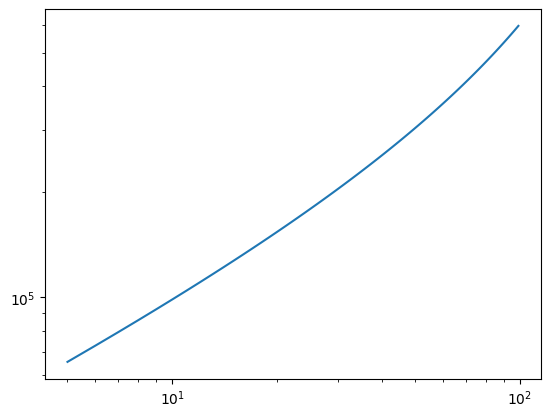

In [152]:
plt.plot(
    radii,
    np.log(.5) / np.log(1 - dest1 / L**2)
)

# plt.plot(
#     radii,
#     np.log(.5) / np.log(1 - dest2 / L**2)
# )

# plt.plot(
#     radii,
#     radii**.5
# )

# plt.plot(
#     radii,
#     np.log(.5) / np.log(1 - dest2 / L**2),
#     ls="dashed"
# )

plt.xscale("log")
plt.yscale("log")

## Plotting taylor approx for alpha < 2

In [61]:
def alpha_lt_2_taylor_approx(
    r: float,
    alpha: float,
    mrp: float,
    r_min: float,
    r_max: float,
    L: float
):
    part1 = -L**2 * np.log(mrp) * (1 - (r_min/r_max)**alpha)*(alpha - 2)
    part2 = (alpha * np.pi * r_min**alpha * ((r/r_min)**(2-alpha) - r_max**(2-alpha)))
    return part1 / part2

def alpha_gt_2_taylor_approx(
    r: float,
    alpha: float,
    mrp: float,
    r_min: float,
    r_max: float,
    L: float
):
    part1 = -L**2 * np.log(mrp) * (1 - (r_min/r_max)**alpha)*(alpha -2)
    part2 = (alpha * np.pi * r_min**alpha * (r/r_min)**(2-alpha))
    return part1 / part2

def exp_destruction_truncated(
    r: float,
    alpha: float,
    r_min: float,
    r_max: float,
    erat: float
):
    part1 = alpha * np.pi * r_min**alpha / ((1 - (r_min/r_max)**alpha) * (alpha - 2))
    part2 = (r/erat)**(2 - alpha) - r_max**(2 - alpha)
    return part1 * part2

In [95]:
alpha = 2.5
mrp = 0.5
r_min = 3
r_max = 1000
L = 50000

r = np.array(range(5, 100))
approx_gt_2 = alpha_gt_2_taylor_approx(
    r,
    alpha,
    mrp,
    r_min,
    r_max,
    L
)

In [96]:
approx_lt_2 = alpha_lt_2_taylor_approx(
    r,
    1.5,
    mrp,
    r_min,
    r_max,
    L
)

In [97]:
psi = exp_destruction_truncated(
    r,
    alpha,
    r_min,
    r_max,
    1.0
)

lmbda = np.log(mrp) / np.log(1 - psi / L**2)

In [98]:
psi

array([101.76282918,  92.22166634,  84.80627889,  78.82890716,
        73.87776258,  69.68924145,  66.08573383,  62.9426205 ,
        60.1695377 ,  57.69914975,  55.4801147 ,  53.47250967,
        51.64476016,  49.97152176,  48.43218379,  47.00979007,
        45.69024582,  44.46172539,  43.31422319,  42.23920864,
        41.22935793,  40.27834299,  39.38066398,  38.53151492,
        37.72667502,  36.96242018,  36.23545028,  35.54282906,
        34.88193409,  34.25041499,  33.6461581 ,  33.06725676,
        32.51198591,  31.97878045,  31.46621666,  30.9729962 ,
        30.49793225,  30.03993751,  29.5980137 ,  29.17124239,
        28.75877703,  28.3598358 ,  27.97369545,  27.59968573,
        27.2371845 ,  26.88561343,  26.54443406,  26.21314432,
        25.89127551,  25.57838941,  25.27407584,  24.97795035,
        24.68965222,  24.4088426 ,  24.1352028 ,  23.86843282,
        23.60824995,  23.35438748,  23.1065936 ,  22.86463031,
        22.62827249,  22.397307  ,  22.17153186,  21.95

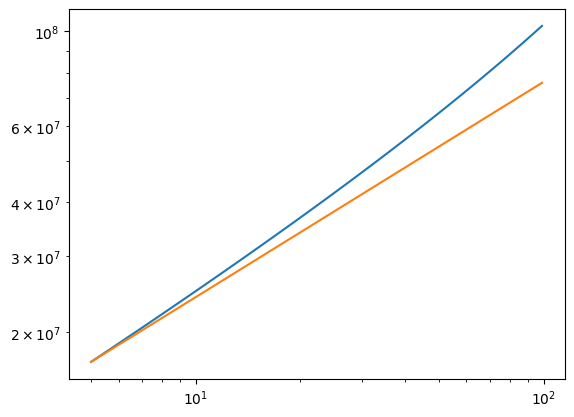

In [99]:
plt.plot(
    r,
    lmbda
)


y = r**(alpha - 2)
y = (y/y[0]) * lmbda[0]
plt.plot(
    r,
    (approx_gt_2/approx_gt_2[0]) * lmbda[0]
)

plt.xscale("log")
plt.yscale("log")

## Testing variance of X^2 trunc pareto

In [157]:
alpha = 1.5
mrp = 0.5
r_min = 3
r_max = 1000
L = 50000

In [191]:
def calc_e_x4(
    r,
    alpha,
    r_min,
    r_max
):
    # term = r_max**(2-alpha) - r_min**(2-alpha)
    term = 1/r_max**(alpha-4) - 1/r_min**(alpha-4)
        
    return alpha * r_min**alpha / ((4 - alpha) * (1 - (r_min/r_max)**alpha)) * term

def calc_e_x2(
    r,
    alpha,
    r_min,
    r_max
):
    term = 1/r_max**(alpha-2) - 1/r_min**(alpha-2)
    return alpha * r_min**alpha / ((2 - alpha) * (1 - (r_min/r_max)**alpha)) * term

In [182]:
calc_e_x2(
    5,
    np.array(range(3, 10)),
    r_min,
    r_max
) - calc_e_x1(
    5,
    np.array(range(3, 10)),
    r_min,
    r_max
)

array([22.41904111, 13.99983811, 11.2499996 ,  9.9       ,  9.1       ,
        8.57142857,  8.19642857])

In [197]:
calc_e_x4(
    5,
    1.1,
    r_min,
    r_max
) - (calc_e_x2(
    5,
    1.1,
    r_min,
    r_max
))**2

633437508.0760909

## Testing new functions

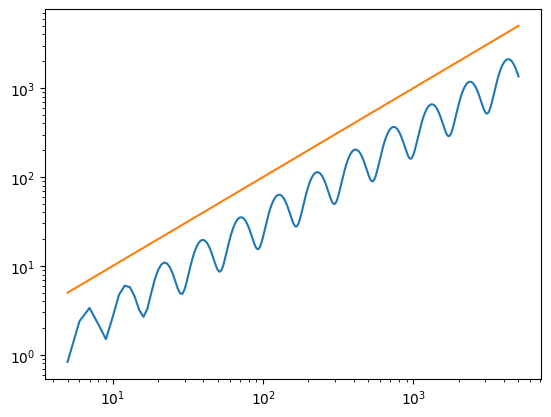

In [10]:
n_periods = 7
r_min_period = 5
r_max_period = 300

radii = np.array(range(5, 5000))
y = (np.sin(np.log(radii) * 2 * np.pi / np.log(r_max_period/r_min_period) * n_periods) + 2) * radii / 6

plt.plot(
    radii,
    y
)

plt.plot(
    radii,
    radii
)

# plt.plot(
#     radii,
#     radii / 3
# )

plt.xscale("log")
plt.yscale("log")

In [ ]:
radii = np.array(range(5, 5000))
energy = radii**3
y = radii

plt.plot(
    radii,
    y
)

plt.plot(
    radii,
    radii
)

# plt.plot(
#     radii,
#     radii / 3
# )

plt.xscale("log")
plt.yscale("log")

In [11]:
(radii / y).max()

np.float64(5.9999990230545635)

In [33]:
import numpy as np
import numba as nb


@nb.njit(fastmath=True)
def calc_thing(lmbda, t):
    result = np.zeros(len(lmbda))
    semi_result = np.ones(len(lmbda))
    for x in range(t+1):
        semi_result *= (1 - 1/lmbda)
        result += semi_result
    return result
    

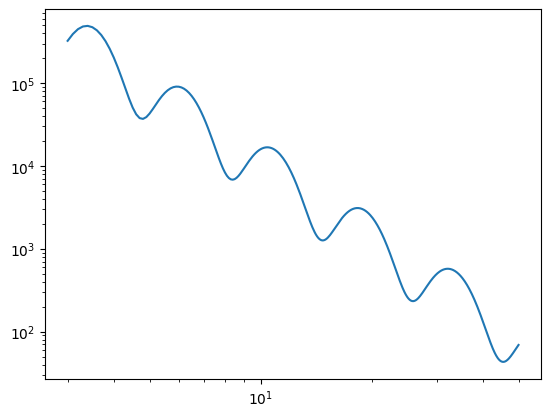

In [3]:
# Trying to show the equilibrium distribution
n_periods = 5
r_min_period = 3
r_max_period = 50
alpha = 3.5
S = 500

resolution = 10

radii = (np.array(range(r_min_period * resolution, r_max_period * resolution)) / resolution).astype(np.float64)
orig_y = (np.sin(np.log(radii) * 2 * np.pi / np.log(r_max_period/r_min_period) * n_periods) + 2) * radii * 8
y = 1/orig_y**(alpha - 2)
el = np.log(.5) / np.log(1 - y / S**2)
act = el / radii ** (alpha + 1)
# y = np.sum([(1 - 1/el)**t for t in range(1000)], axis=0)

# plt.plot(
#     radii,
#     calc_thing(el, 100000)/ radii ** (alpha + 1)
# )

# diff = calc_thing(el, 10000000)/ radii ** (alpha + 1)
# cumulative = np.flip(np.flip(diff).cumsum())

# plt.plot(
#     radii,
#     diff, #cumulative
# )


# plt.plot(
#     radii,
#     cumulative
# )

plt.plot(
    radii,
    act
)

# plt.plot(
#     radii,
#     calc_thing(el, 40000000)/ radii ** (alpha + 1)
# )

# plt.plot(
#     radii,
#     radii / 3
# )

plt.xscale("log")
plt.yscale("log")

In [60]:
r_min_period / (orig_y / radii).max()

np.float64(0.5000051038415053)

In [322]:
10**3.5

3162.2776601683795

In [88]:
def calc_integral(r, alpha):
    return -1/r**(alpha-1) * ((alpha - 1) * np.sin(np.log(r) + 2) + np.cos(np.log(r) + 2)) / (alpha**2 - 2*alpha + 2)

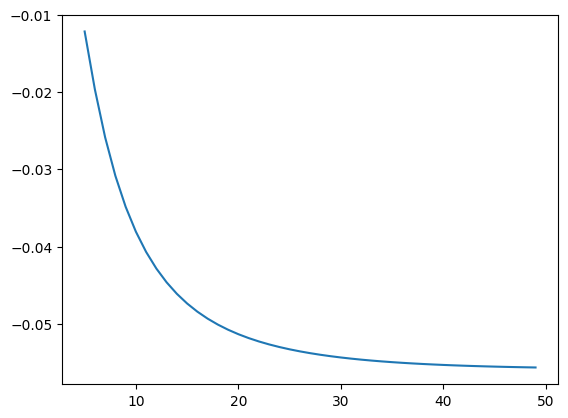

In [90]:
radii = np.array(range(5, 50))
y = calc_integral(radii, alpha) - calc_integral(3, alpha)

plt.plot(
    radii,
    y
)

# plt.xscale("log")
# plt.yscale("log")

In [324]:
(radii / y).max()

np.float64(3.9988550967851513)